# Next Tasks

* Prepare the ME data, i.e., create .pkl file for each split containing `{‘video_id’: int, ‘caption’: str, ‘scores’: (2,)}` for each sample (8000 train + 2000 test).
* Preprocessing linguistic input (cleaning-up + tokenizing + tensorizing): `[{‘video_id’: int, ‘caption’: str, ‘c_token’: (23,), ‘c_input_mask’: (23,), ‘c_segment_id’: (23,)}]`
* Adapt the model for the ME data input 
* Choose a representative frame for each video and extract visual features
`{‘bbox’: (100,4), ‘num_boxes’: int = 100, ‘objects’: (99,), ‘image_width’: int, ‘image_height’: int, ‘cls_prob’: (100,1601), ‘image_id’: int, ‘features’: (100,2048)}`


# VQA data structure

In [1]:
!tree -L 2 /aloui/vilbert-multi-task/datasets/VQA

/aloui/vilbert-multi-task/datasets/VQA
|-- cache
|   |-- VQA_minval_16.pkl
|   |-- VQA_minval_23.pkl
|   |-- VQA_minval_23_cleaned.pkl
|   |-- VQA_test_23_cleaned.pkl
|   |-- VQA_trainval_16.pkl
|   |-- VQA_trainval_23.pkl
|   |-- VQA_trainval_23_cleaned.pkl
|   |-- VQA_trainval_23_cleaned_final.pkl
|   |-- VQA_trainval_23_cleanedfinal.pkl
|   |-- coco_test_ids.npy
|   |-- coco_test_ids_small.npy
|   |-- train_target.pkl
|   |-- trainval_ans2label.pkl
|   |-- trainval_label2ans.pkl
|   `-- val_target.pkl
|-- v2_OpenEnded_mscoco_test-dev2015_questions.json
|-- v2_OpenEnded_mscoco_test2015_questions.json
|-- v2_OpenEnded_mscoco_train2014_questions.json
|-- v2_OpenEnded_mscoco_val2014_questions.json
|-- v2_mscoco_train2014_annotations.json
`-- v2_mscoco_val2014_annotations.json

1 directory, 21 files


In [2]:
!tree -L 2 /aloui/vilbert-multi-task/datasets/coco/features_100

/aloui/vilbert-multi-task/datasets/coco/features_100
|-- COCO_test_resnext152_faster_rcnn_genome.lmdb
|   `-- data.mdb
`-- COCO_trainval_resnext152_faster_rcnn_genome.lmdb
    `-- data.mdb

2 directories, 2 files


In [3]:
!tree -L 2 /aloui/vilbert-multi-task/datasets/ME

/aloui/vilbert-multi-task/datasets/ME
|-- cache
|   |-- ME_minval_23_cleaned.pkl
|   |-- ME_test_23_cleaned.pkl
|   `-- ME_trainval_23_cleaned.pkl
|-- features_100
|   |-- ME_test_resnext152_faster_rcnn_genome.lmdb
|   `-- ME_trainval_resnext152_faster_rcnn_genome.lmdb
`-- images
    |-- test
    `-- train

7 directories, 3 files


```
TASK19:
  name: ME
  type: VL-classifier
  loss: BCEWithLogitLoss
  process: normal
  task_id: 19
  dataroot: datasets/ME/
  features_h5path1: datasets/ME/features_100/COCO_test_resnext152_faster_rcnn_genome.lmdb
  features_h5path2: ''
  train_annotations_jsonpath: ''
  val_annotations_jsonpath: ''
  max_seq_length: 23
  max_region_num: 101
  batch_size: 64
  eval_batch_size: 1024
  train_split: trainval
  val_split: minval
  lr: 0.00004
  num_epoch: 20
```
  
NB: This config is not up-to-date.

# Create cache files for the ME dataset

## Retrieve video_id and caption

In [1]:
import re
import os
import _pickle as cPickle
import numpy as np
import torch
from pytorch_transformers.tokenization_bert import BertTokenizer

In [2]:
cPickle.load(open('datasets/VQA/cache/VQA_minval_23_cleaned.pkl', 'rb'))[0]

{'question_id': 573843005,
 'image_id': 573843,
 'question': 'Are there clouds?',
 'answer': {'labels': tensor([ 425, 1403]),
  'scores': tensor([1.0000, 0.3000])},
 'q_token': tensor([ 101, 2024, 2045, 8044, 1029,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'q_input_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'q_segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [6]:
cPickle.load(open('datasets/VQA/cache/VQA_test_23_cleaned.pkl', 'rb'))[0]

{'image_id': 1,
 'question': 'What is the fence made of?',
 'question_id': 1000,
 'q_token': tensor([ 101, 2054, 2003, 1996, 8638, 2081, 1997, 1029,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'q_input_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'q_segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [7]:
!head /aloui/MediaEval/dev-set/dev-set_video-captions.txt

video10.webm	couple-relaxing-on-picnic-crane-shot
video100.webm	cute-black-and-white-cats-in-cage-at-animal-shelter
video10000.webm	owl-in-tree-close-up
video10001.webm	around-the-house-on-a-laptop
video10002.webm	beautiful-young-girl-with-apple
video10003.webm	family-of-four-stands-at-barrier-on-bridge-in-city-to-observe-nature-as-the-sun-sets-beyond-the-tree-line
video10004.webm	astronaut-in-outer-space-against-the-backdrop-of-the-planet-earth-elements-of-this-image-furnished-by-nasa
video10005.webm	young-women-lying-on-sunbed-and-applying-sun-cream
video10006.webm	doctor-talking-to-patient-using-a-tablet-to-explain-her-condition
video10007.webm	businessman-sitting-on-the-beach-on-inflatable-mattress-and-working-on-laptop


In [3]:
max_length = 23
train_split = 'trainval'
val_split = 'minval'
test_split = 'test'
dataroot = 'datasets/ME'
train_cache_path = os.path.join(dataroot, 'cache', 'ME' + '_' + train_split + '_' + str(max_length) + '_' + 'cleaned' + '.pkl')
val_cache_path = os.path.join(dataroot, 'cache', 'ME' + '_' + val_split + '_' + str(max_length) + '_' + 'cleaned' + '.pkl')
test_cache_path = os.path.join(dataroot, 'cache', 'ME' + '_' + test_split + '_' + str(max_length) + '_' + 'cleaned' + '.pkl')

In [4]:
train_caption_path = '/aloui/MediaEval/dev-set/dev-set_video-captions.txt'
test_caption_path = '/aloui/MediaEval/test-set/test-set_video-captions.txt'


with open(train_caption_path, 'r') as f:
    lines = f.readlines()
train_entries = []
for line in lines:
    sample = {}
    vid_name, caption = line.split('\t')
    vid_id = re.findall(r'\d+', vid_name)[0]
    caption = caption.rstrip().replace('-', ' ')
    sample['video_id'] = int(vid_id)
    sample['caption'] = caption
    train_entries.append(sample)
    
with open(test_caption_path, 'r') as f:
    lines = f.readlines()
test_entries = []
for line in lines:
    sample = {}
    vid_name, caption = line.split('\t')
    vid_id = re.findall(r'\d+', vid_name)[0]
    caption = caption.rstrip().replace('-', ' ')
    sample['video_id'] = int(vid_id)
    sample['caption'] = caption
    test_entries.append(sample)

In [5]:
train_entries[0]

{'video_id': 10, 'caption': 'couple relaxing on picnic crane shot'}

## Add scores

In [6]:
import pandas as pd

In [7]:
train_df = pd.read_csv('/aloui/MediaEval/dev-set/ground-truth/ground-truth_dev-set.csv')
train_df.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video10.webm,0.950,34,0.900,10
1,video100.webm,0.951,33,0.889,9
2,video10000.webm,0.832,33,1.000,13
3,video10001.webm,0.865,33,0.727,11
4,video10002.webm,0.899,59,0.792,24


In [8]:
score_dict = {}
for r in train_df.itertuples():
    vid_id = re.findall(r'\d+', r.video)[0]
    vid_id = int(vid_id)
    score_dict[vid_id] = [r._2, r._4]

In [9]:
for sample in train_entries:
    sample['scores'] = score_dict[sample['video_id']]

In [10]:
train_entries[0]

{'video_id': 10,
 'caption': 'couple relaxing on picnic crane shot',
 'scores': [0.95, 0.9]}

## Add tokens

In [11]:
def assert_eq(real, expected):
    assert real == expected, "%s (true) vs %s (expected)" % (real, expected)

In [12]:
def tokenize(entries, tokenizer, max_length=16, padding_index=0):
    """Tokenizes the questions.

    This will add q_token in each entry of the dataset.
    -1 represent nil, and should be treated as padding_index in embedding
    """
    for entry in entries:
        tokens = tokenizer.encode(entry["caption"])
        tokens = tokens[: max_length - 2]
        tokens = tokenizer.add_special_tokens_single_sentence(tokens)

        segment_ids = [0] * len(tokens)
        input_mask = [1] * len(tokens)

        if len(tokens) < max_length:
            # Note here we pad in front of the sentence
            padding = [padding_index] * (max_length - len(tokens))
            tokens = tokens + padding
            input_mask += padding
            segment_ids += padding

        assert_eq(len(tokens), max_length)
        entry["c_token"] = tokens
        entry["c_input_mask"] = input_mask
        entry["c_segment_ids"] = segment_ids

In [13]:
bert_model = 'bert-base-uncased'
do_lower_case = True

tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)

In [14]:
tokenize(train_entries, tokenizer, max_length=max_length)

In [15]:
tokenize(test_entries, tokenizer, max_length=max_length)

In [16]:
train_entries[0].keys()

dict_keys(['video_id', 'caption', 'scores', 'c_token', 'c_input_mask', 'c_segment_ids'])

## Tensorize

In [17]:
def tensorize(entries, split='trainval'):

    for entry in entries:
        caption = torch.from_numpy(np.array(entry["c_token"]))
        entry["c_token"] = caption

        c_input_mask = torch.from_numpy(np.array(entry["c_input_mask"]))
        entry["c_input_mask"] = c_input_mask

        c_segment_ids = torch.from_numpy(np.array(entry["c_segment_ids"]))
        entry["c_segment_ids"] = c_segment_ids

        if "test" not in split:
            # answer = entry["answer"]
            # labels = np.array(answer["labels"])
            scores = np.array(entry["scores"], dtype=np.float32)

            scores = torch.from_numpy(scores)
            entry["scores"] = scores
            # entry["answer"]["scores"] = scores

            '''if len(labels):
                labels = torch.from_numpy(labels)
                scores = torch.from_numpy(scores)
                entry["answer"]["labels"] = labels
                entry["answer"]["scores"] = scores
            else:
                entry["answer"]["labels"] = None
                entry["answer"]["scores"] = None'''

In [18]:
tensorize(train_entries, split='trainval')

In [19]:
tensorize(test_entries, split='test')

In [20]:
train_entries[0]

{'video_id': 10,
 'caption': 'couple relaxing on picnic crane shot',
 'scores': tensor([0.9500, 0.9000]),
 'c_token': tensor([  101,  3232, 19613,  2006, 12695, 11308,  2915,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]),
 'c_input_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'c_segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [29]:
len(train_entries)

8000

In [27]:
#val_entries, train_entries = np.split(train_entries, [2000])
#val_entries, train_entries = list(val_entries), list(train_entries)

In [24]:
#len(np.split(train_entries, [2000, 4000, 6000]))

4

In [ ]:
#for i, sp in enumerate(np.split(train_entries, [2000, 4000, 6000])):
#    t_split = list(sp)
#    cPickle.dump(train_entries, open(train_cache_path, 'wb'))

In [30]:
# this done only once to save entries to the disk
cPickle.dump(train_entries, open(train_cache_path, 'wb'))
# cPickle.dump(val_entries, open(val_cache_path, 'wb'))
cPickle.dump(test_entries, open(test_cache_path, 'wb'))

In [31]:
cPickle.load(open('datasets/ME/cache/ME_test_23_cleaned.pkl', 'rb'))[1]

{'video_id': 1000,
 'caption': 'clown fish swimming by rocks and coral',
 'c_token': tensor([  101, 15912,  3869,  5742,  2011,  5749,  1998, 11034,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]),
 'c_input_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'c_segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

# Extract the middle frame and save to disk

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
import re

In [2]:
train_video_dir = '/aloui/MediaEval/dev-set/sources/'
test_video_dir = '/aloui/MediaEval/test-set/sources/'

train_image_dir = 'datasets/ME/images/train/'
test_image_dir = 'datasets/ME/images/test/'

In [59]:
test_im_dict = dict()

for k, filename in enumerate(tqdm(os.listdir(test_video_dir))):
    if filename.endswith(".webm"):
        vid_id = re.findall(r'\d+', filename)[0]
        vid_id = int(vid_id)
        video_path = os.path.join(test_video_dir, filename)
        cap = cv2.VideoCapture(video_path)
        i = 0
        frames = list()
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break
            frames.append(frame)
            i += 1
        center_frame = frames[i // 2]
        test_im_dict[vid_id] = center_frame
        # cv2.imwrite(str(vid_id)+'.jpg', center_frame)
cap.release()
cv2.destroyAllWindows()

100%|██████████| 2000/2000 [20:36<00:00,  1.59it/s]


In [137]:
random.seed(a=42)
sampled_list = random.sample(test_entries, 6)

sampled_tuple = list()

for sample in sampled_list:
    v_id = sample['video_id']
    v_caption = sample['caption']
    img = test_im_dict[v_id]
    sampled_tuple.append((v_id, v_caption, img))

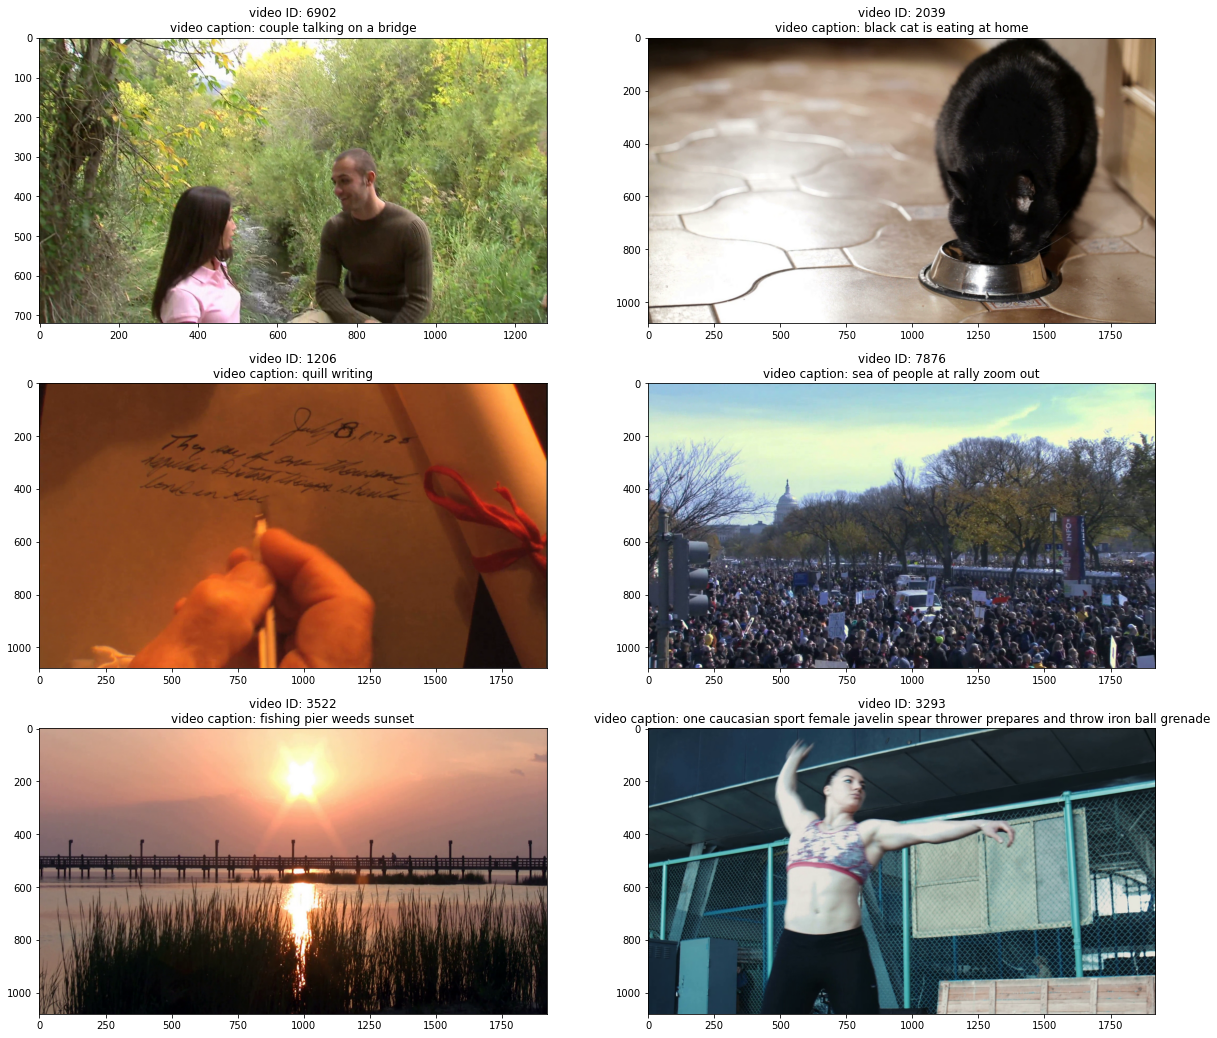

In [144]:
fig, axes = plt.subplots(3, 2, figsize=(20,18))

for i, (v_id, v_caption, img) in enumerate(sampled_tuple):
    axes[i // 2, i % 2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i // 2, i % 2].set_title("video ID: %d\nvideo caption: %s" %(v_id, v_caption))

In [77]:
for v_id, img in tqdm(test_im_dict.items()):
    cv2.imwrite(test_image_dir + str(v_id) + '.jpg', img)

100%|██████████| 2000/2000 [00:45<00:00, 43.89it/s]


In [5]:
im_dict = dict()
for k, filename in enumerate(tqdm(os.listdir(train_video_dir))):
    vid_id = re.findall(r'\d+', filename)[0]
    vid_id = int(vid_id)
    if filename.endswith(".webm") and not os.path.exists(train_image_dir + str(vid_id) + '.jpg'):
        video_path = os.path.join(train_video_dir, filename)
        cap = cv2.VideoCapture(video_path)
        i = 0
        frames = list()
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break
            frames.append(frame)
            i += 1
        center_frame = frames[i // 2]
        # im_dict_2[vid_id] = center_frame
        cv2.imwrite(train_image_dir + str(vid_id) + '.jpg', center_frame)
        cap.release()
        cv2.destroyAllWindows()

100%|██████████| 8000/8000 [04:55<00:00,  1.65it/s]   
